In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# this sets up astropy
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance

# First Check
Now we calculate the p(z) of our neighbors.

In [3]:
tentative = pd.read_csv('potential_neighbors.txt', sep='\t')
tentative_ids = tentative['id'].values

In [4]:
all_probs = np.zeros(np.size(tentative_ids))

In [5]:
all_pdf_grids = []
all_pdf_probs = []

In [6]:
for idx in range(np.size(tentative_ids)):

    id = tentative_ids[idx]
    print(str(idx) + ', to keep track')
    
    fname = '/Users/ngbinh/out_properties/' + str(id) + '_universe.redshift_chi2-block-0.npy'
    
    likelihood = []
    model_variable = []

    data = np.memmap(fname, dtype=np.float64)
    data = np.memmap(fname, dtype=np.float64, shape=(2, data.size // 2))
    
    likelihood.append(np.exp(-data[0, :] / 2.0))
    model_variable.append(data[1, :])
    
    if len(likelihood) > 0:
        likelihood = np.concatenate(likelihood)
        model_variable = np.concatenate(model_variable)
        w = np.where(np.isfinite(likelihood) & np.isfinite(model_variable))
        likelihood = likelihood[w]
        model_variable = model_variable[w]
    
        Npdf = 100
        min_hist = np.min(model_variable)
        max_hist = np.max(model_variable)
        Nhist = min(Npdf, len(np.unique(model_variable)))
    
        if min_hist == max_hist:
            pdf_grid = np.array([min_hist, max_hist])
            pdf_prob = np.array([1.0, 1.0])
        else:
            pdf_prob, pdf_grid = np.histogram(
                        model_variable,
                        Nhist,
                        (min_hist, max_hist),
                        weights=likelihood,
                        density=True,
                    )
            pdf_x = (pdf_grid[1:] + pdf_grid[:-1]) / 2.0
    
            pdf_grid = np.linspace(min_hist, max_hist, Npdf)
            pdf_prob = np.interp(pdf_grid, pdf_x, pdf_prob)

        all_pdf_grids.append(pdf_grid)
        all_pdf_probs.append(pdf_prob)

0, to keep track
1, to keep track
2, to keep track
3, to keep track
4, to keep track
5, to keep track
6, to keep track
7, to keep track
8, to keep track
9, to keep track
10, to keep track
11, to keep track
12, to keep track
13, to keep track
14, to keep track
15, to keep track
16, to keep track
17, to keep track
18, to keep track
19, to keep track
20, to keep track
21, to keep track
22, to keep track
23, to keep track
24, to keep track
25, to keep track
26, to keep track
27, to keep track
28, to keep track
29, to keep track
30, to keep track
31, to keep track
32, to keep track
33, to keep track
34, to keep track
35, to keep track
36, to keep track
37, to keep track
38, to keep track
39, to keep track
40, to keep track
41, to keep track
42, to keep track
43, to keep track
44, to keep track
45, to keep track
46, to keep track
47, to keep track
48, to keep track
49, to keep track
50, to keep track
51, to keep track
52, to keep track
53, to keep track
54, to keep track
55, to keep track
56

Now, we find the percentages for all the neighbors, based on the z$_{spec}$ of their respective host galaxies.

In [8]:
our_id_saved = pd.read_csv('neighbor_data.csv')[['id', 'our_id']]
full_data = pd.concat([pd.merge(our_id_saved, tentative, how='right', on='id') 
                    for dfe in [our_id_saved, tentative]], ignore_index=True).drop_duplicates()

In [9]:
full_data

,id,our_id,ra,dec,host_ra,host_dec
0,756228,0,150.061200,2.374627,150.061490,2.378680
1,756324,0,150.062186,2.375231,150.061490,2.378680
2,756381,0,150.058607,2.377135,150.061490,2.378680
3,756542,0,150.064461,2.376458,150.061490,2.378680
4,756650,0,150.059622,2.379230,150.061490,2.378680
...,...,...,...,...,...,...
154,823998,8,150.106560,2.333423,150.108873,2.330539
155,824034,8,150.108001,2.333181,150.108873,2.330539
156,824065,8,150.112878,2.331558,150.108873,2.330539
157,824112,8,150.110146,2.332911,150.108873,2.330539


In [10]:
# now read in the RAs and Decs of our 9 galaxies to match them to Hollis's table
info = pd.read_csv('basic_data.txt', delimiter=' ', names=['name', 'RA', 'Dec', 'spec_z'])
spec_z_array = info['spec_z'].values

In [11]:
info

,name,RA,Dec,spec_z
0,Hong,150.061490,2.378680,3.715
1,Bach-Dang,150.112560,2.376527,2.474
2,Gianh,150.066710,2.382364,3.715
3,Ben-Hai,150.087280,2.396043,3.782
4,Huong-Giang,150.437320,2.463920,3.336
5,Thu-Bon,150.454590,2.455994,3.757
6,Dong-Nai,150.461200,2.429547,4.673
7,Saigon,150.106932,2.377961,4.570
8,Tien,150.108873,2.330539,3.238


In [12]:
percent_list = []

for i in range(np.size(tentative_ids)):
    this_id = tentative_ids[i]

    # this locates the spec_z of the host galaxy by retrieving the "our_id" number. the reason why 
    # there are so many brackets is because we're cross-checking many different pandas frames.
    spec_z = spec_z_array[full_data[full_data['id']==this_id]['our_id']][0]

    # this integrates the area under the curve from (spec_z - 0.5) to 9.8, which is the upper limit
    # that we set when we ran CIGALE. the difference of 0.5 is to account for any neighbor
    # that doesn't exactly have the same redshift as the spec_z of their host galaxy.
    percent = np.trapz(all_pdf_probs[i], x=[(spec_z - 0.5), 9.8])

    # this saves the integration result into the empty list we made outside the for loop
    percent_list.append(percent)

    print(full_data[full_data['id']==this_id]['our_id'].values[0], this_id, spec_z, percent)

0 756228 3.715 73.58286515801981
0 756324 3.715 73.9195532656218
0 756381 3.715 73.46905544698583
0 756542 3.715 73.74268321466353
0 756650 3.715 73.46911849368352
0 756791 3.715 73.46913260290422
0 756809 3.715 73.77655104690785
0 756895 3.715 73.75024963468273
0 756931 3.715 73.65326191597805
0 780235 3.715 73.79567960120916
0 780261 3.715 73.95929098438603
0 780365 3.715 74.15515416469569
0 780483 3.715 74.01043245043691
0 780489 3.715 73.57163347403998
0 780511 3.715 74.28354523770594
0 780592 3.715 74.35740942261847
0 780808 3.715 74.24830010200054
0 780830 3.715 74.53938363151161
0 780870 3.715 73.80660177513333
0 780882 3.715 74.761825269953
0 780995 3.715 73.4721739665819
0 781053 3.715 74.26589572984014
0 781056 3.715 73.74370973594898
1 757782 2.474 89.13393595041316
1 757931 2.474 87.31487603306057
1 757934 2.474 88.27412888773632
1 757952 2.474 88.60976733263098
1 757967 2.474 87.31487607312692
1 758035 2.474 87.31487603305783
1 758076 2.474 88.34082132764173
1 758096 2.474

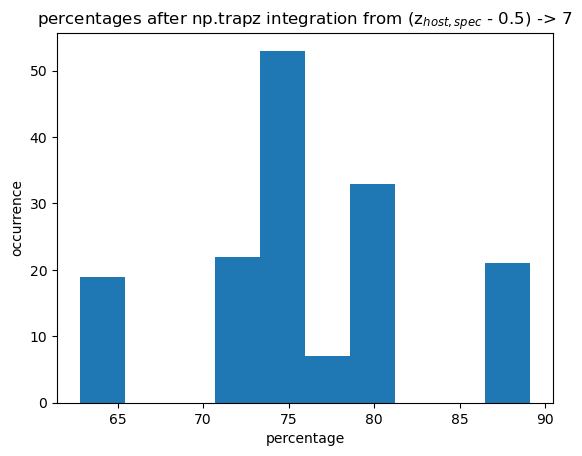

In [13]:
plt.hist(percent_list)
plt.title('percentages after np.trapz integration from (z$_{host,spec}$ - 0.5) -> 7')
plt.xlabel('percentage')
plt.ylabel('occurrence')
plt.show()

In [14]:
percent_list = np.array(percent_list, dtype='object')

In [15]:
percent_list[percent_list <= 62]

array([], dtype=object)

This means the minimum threshold for all of them to pass is 62%.

In [17]:
np.size(percent_list[percent_list > 70])/np.size(percent_list) * 100

87.74193548387098

This means 87.74% of the galaxies have a percentage above 70%. The remaining ones are the high-redshift Dong-Nai and Saigon.

In [19]:
np.mean(percent_list[percent_list < 70])

63.975622829077125

This means that for the high-redshift Dong-Nai and Saigon, their candidate neighbors have an average p(z) of 63.97%.

# Second Check
Now we'll see if our 155 neighbors have a SNR > 5.

In [22]:
# this is the name of the BIG catalog file
large_catalog = '/Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits'

# this opens the HDU list of the .fits files and asks for the information within. SCI is what we'll use
hdu_list = fits.open(large_catalog)
hdu_list.info()

# this saves the WCS setting to be used later
wcs = WCS(hdu_list[1].header)

# this gets the data of the big catalog. "cat" stands for catalog!
cat_data = hdu_list[1].data

Filename: /Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    802   913253R x 155C   [K, D, D, 3A, D, 4A, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, K, E, E, K, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [23]:
# now retrieve all the SNRs from Hollis's catalog, then save them into respective lists.
snr_115 = []
snr_150 = []
snr_277 = []
snr_444 = []

for j in range(np.size(tentative_ids)):
    idx = tentative_ids[j]
    snr_115.append(cat_data[cat_data['id']==idx]['snr_f115w'][0])
    snr_150.append(cat_data[cat_data['id']==idx]['snr_f150w'][0])
    snr_277.append(cat_data[cat_data['id']==idx]['snr_f277w'][0])
    snr_444.append(cat_data[cat_data['id']==idx]['snr_f444w'][0])

In [24]:
# now make a dataframe with just the Hollis ID and the SNRs.
# first, we'll create a dictionary.
mega_dict = {}

# now let's start populating the dictionary
mega_dict['id'] = tentative_ids.tolist()
mega_dict['snr_f115w'] = snr_115
mega_dict['snr_f150w'] = snr_150
mega_dict['snr_f277w'] = snr_277
mega_dict['snr_f444w'] = snr_444

# lastly, convert the dictionary into a pandas frame
snr_df = pd.DataFrame(mega_dict)
snr_df

,id,snr_f115w,snr_f150w,snr_f277w,snr_f444w
0,756228,3.222476,12.093024,44.373672,27.513658
1,756324,1.756333,8.076986,31.684505,23.501249
2,756381,11.940819,18.043528,59.427953,35.939066
3,756542,6.132267,6.663732,28.903535,27.219162
4,756650,4.370914,2.239359,73.274458,69.476881
...,...,...,...,...,...
150,823998,5.796392,9.490119,22.310756,11.874691
151,824034,2.661938,6.969262,19.388323,10.323226
152,824065,2.398271,6.636055,12.022946,5.576203
153,824112,7.545264,2.715796,1.697239,1.017422


In [25]:
# now, let's see how many of them have SNR > 5
# this empty list will save the Hollis IDs that pass this criterion
idx_5sigma_pass = [] 

# this loops through all the Hollis IDs
for id in tentative_ids:
    
    # this locates the four SNR values associated with each Hollis ID
    snr_row = snr_df[snr_df['id'] == id].values[0][1:]

    # this checks to see if any of the SNR values is GREATER than 5.
    if np.size(snr_row[snr_row > 5]) != 0:
        # to see the actual number of SNR values greater than 5, uncomment this
        # print(np.size(snr_row[snr_row > 5]))
        # to see the SNRs that are greater than 5 for themselves, uncomment this
        # print(snr_row[snr_row > 5])
        # this adds the id that passes the criterion into the empty list
        idx_5sigma_pass.append(id)

print(np.size(idx_5sigma_pass))

155


In [26]:
# after we know all of the galaxies pass this criterion, let's see which band has the most SNRs > 5.
for column in snr_df:
    if column != 'id':
        print(column, np.size(snr_df[column].values[snr_df[column].values > 5]))

snr_f115w 79
snr_f150w 102
snr_f277w 154
snr_f444w 138


In [27]:
# now we do a secondary check for the ones with z < 4, since we have 
# two outlying z > 4.5 host galaxies that might skew our data.
outlying_ids = full_data['id'][full_data['our_id'].isin([6, 7])].values

# next, we find the indices of these outlying ids in tentative_ids
z_less_than_4 = snr_df[snr_df['id'].isin(outlying_ids)==False]

# now we read through the pandas frame and find the column (i.e. the band)
# where most of the SNRs are greater than 5
for column in z_less_than_4:
    if column != 'id':
        print(column, np.size(z_less_than_4[column].values[z_less_than_4[column].values > 5]))

snr_f115w 68
snr_f150w 90
snr_f277w 135
snr_f444w 121
